# Sentiment Based Product Recommendation System
## Capstone project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from numpy import *

from textaugment import Wordnet, Word2vec
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Amit\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [142]:
import joblib

In [2]:
import string
import re
#nltk.download()
# nltk.download('averaged_perceptron_tagger')

### Importing data

In [3]:
# Importing and viewing data
df = pd.read_csv("C://Users//Amit//Desktop//Deployment//model_files//sample30.csv")
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Data Cleaning & Pre-Processing

In [4]:
# CHecking for percentage of null values for each variable
df.isnull().sum()/len(df['user_sentiment'])*100 

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

In [5]:
# Dropping reviews_userCity, reviews_userProvince, and reviews_didPurchase because it has lot of missing values
df = df.drop(['reviews_userCity', 'reviews_userProvince', 'reviews_didPurchase'], 1)
df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive


In [6]:
# droping rows with na values
df = df.dropna()

In [7]:
# CHecking for percentage of null values for each variable
df.isnull().sum()/len(df['user_sentiment'])*100

id                     0.0
brand                  0.0
categories             0.0
manufacturer           0.0
name                   0.0
reviews_date           0.0
reviews_doRecommend    0.0
reviews_rating         0.0
reviews_text           0.0
reviews_title          0.0
reviews_username       0.0
user_sentiment         0.0
dtype: float64

In [8]:
# Total number of brands
print(f"The number of different brands are {len(df['brand'].value_counts())}")

The number of different brands are 163


In [9]:
# CHecking for data imbalance
df['user_sentiment'].value_counts()

Positive    24319
Negative     2911
Name: user_sentiment, dtype: int64

In [10]:
# Proportion of classes in dataset
df['user_sentiment'].value_counts()/len(df['user_sentiment'])*100

Positive    89.309585
Negative    10.690415
Name: user_sentiment, dtype: float64

# Sentiment Analysis
### Pre-Processing text data

In [11]:
# Extracting text data into a saperate dataframe
text_df = df[['reviews_text', 'reviews_title']]
text_df.head()

,reviews_text,reviews_title
3,I read through the reviews on here before look...,Disappointed
4,My husband bought this gel for us. The gel cau...,Irritation
5,My boyfriend and I bought this to spice things...,Not worth it
6,Bought this earlier today and was excited to c...,Disappointing
7,I bought this product for my husband and I to ...,Not happy at all


In [12]:
# Combining both text columns into one column by string concatenation
# Doing this since the title contains important information about the sentiment
text_df['reviews'] = text_df['reviews_title'] + '. ' + text_df['reviews_text']

# Droping ['reviews_text', 'reviews_title'] since we have already concatinated into the reviews 
text_df = text_df.drop(['reviews_text', 'reviews_title'], 1)

# Adding the column that contains the class
text_df['user_sentiment'] = df['user_sentiment']

# Viewig dataframe
text_df.head()

,reviews,user_sentiment
3,Disappointed. I read through the reviews on he...,Negative
4,Irritation. My husband bought this gel for us....,Negative
5,Not worth it. My boyfriend and I bought this t...,Negative
6,Disappointing. Bought this earlier today and w...,Negative
7,Not happy at all. I bought this product for my...,Negative


In [13]:
# Converting floats to int
def remove_float(text):
    # values are split at decimal point
    lst = []
    for each in text:
        lst.append(str(each).split('.')[0])
    
    # all values converting to integer data type
    final_list = [i for i in lst if type(i) != float]
    final_list = ''.join(final_list)
    return final_list

# Remove numbers from string
def remove_digit(text):
    res = ''.join([i for i in text if not i.isdigit()])
    return res

# Defiing function for Removing punctuntion
def remove_punct(text):
    reviews = "".join([l for l in text if l not in string.punctuation])
    return reviews

# Defiing function for Removing extra white spaces
def remove_extra_white_space(text):
    return re.sub(' +',' ',text)

# Defiing function for Removing leading and lagging spaces
def remove_white_strip(text):
    return text.strip()

In [14]:
# Removing floating point digits
text_df['reviews'] = text_df['reviews'].apply(lambda x: remove_float(x))
# Removing ints
text_df['reviews'] = text_df['reviews'].apply(lambda x: remove_digit(x))
# Converting to lower case
text_df['reviews'] = text_df['reviews'].apply(lambda x: x.lower())
# Removing extra white spaces
text_df['reviews'] = text_df['reviews'].apply(lambda x: remove_extra_white_space(x))
# Removing leading and lagging spaces
text_df['reviews'] = text_df['reviews'].apply(lambda x: remove_white_strip(x))
# Removing punctuntion
text_df['reviews'] = text_df['reviews'].apply(lambda x: remove_punct(x))
# Droping text with duplicate rows & Resetting index
text_df = text_df.drop_duplicates(subset='reviews').reset_index(drop = 'True')

# Viewing Dataframe
text_df.head()

,reviews,user_sentiment
0,disappointed i read through the reviews on her...,Negative
1,irritation my husband bought this gel for us t...,Negative
2,not worth it my boyfriend and i bought this to...,Negative
3,disappointing bought this earlier today and wa...,Negative
4,not happy at all i bought this product for my ...,Negative


## Handeling Imbalanced dataset

### Using textaugment

In [15]:
# Sample demonstratation of text augmentation using textaugment
sample_text = text_df['reviews'].iloc[1]
print("Original text:" ,sample_text)

# Augmenting text
t = Wordnet()
print("Augmented text:" ,t.augment(sample_text))

Original text: irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel
Augmented text: irritation my husband purchase this gel for us the gel caused irritation and it finger like it was incinerate my skin i wouldnt recommend this gel


<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

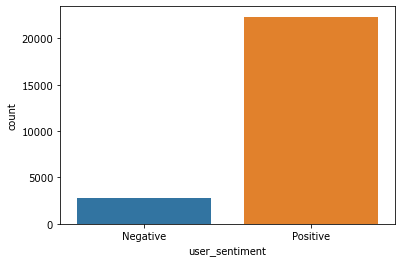

In [16]:
# Visualizing the proportion of 
sns.countplot(text_df['user_sentiment'])

In [17]:
# Creating a dataframe only with the "Negative" class so it can be augmented
text_negative = text_df[text_df['user_sentiment'] == 'Negative']
text_negative = text_negative.reset_index(drop = 'True')
text_negative.head()

,reviews,user_sentiment
0,disappointed i read through the reviews on her...,Negative
1,irritation my husband bought this gel for us t...,Negative
2,not worth it my boyfriend and i bought this to...,Negative
3,disappointing bought this earlier today and wa...,Negative
4,not happy at all i bought this product for my ...,Negative


In [18]:
# Creating an instance of the wordnet for text augmentation
wordnet = Wordnet()

In [19]:
# Calculating the difference between the 2 classes.
no_of_aug = text_df['user_sentiment'].value_counts()[0] - text_df['user_sentiment'].value_counts()[1]

# Creating a function for text augmentation
def aug_text(*text):
    augmented_text = []
    
    # Randomly picking texts from the negative class and augmenting the text and storing it in augmented_text
    for l in range(no_of_aug):
        # Randomly picking a review
        rand = random.randint(0, len(text_negative)-1)
        # Augmenting the randomly picked review
        augmented_text.append(wordnet.augment(text_negative['reviews'].iloc[rand]))
        
    return augmented_text

In [20]:
# Applying the text augmentation function
new_text = aug_text(text_negative['reviews'])

In [21]:
# Creating a new Dataframe and storing the augmented texts in it
new_text_df = pd.DataFrame(new_text, columns=['reviews'])
# Assigning it the negative class.
new_text_df['user_sentiment'] = "Negative"
# Viewing the dataframe
new_text_df.head()

,reviews,user_sentiment
0,dark shadows one of the most horrifying and ve...,Negative
1,excellent movie show fantastic collection of a...,Negative
2,excellent it was just the taste i was looking for,Negative
3,dissapointed there were two seams on the sides...,Negative
4,excellent i dont buy any tortilla chip but the...,Negative


In [22]:
# COmbining the aigmented dataframe with the text dataframe
aug_df = pd.concat((text_df, new_text_df))
aug_df.head()

,reviews,user_sentiment
0,disappointed i read through the reviews on her...,Negative
1,irritation my husband bought this gel for us t...,Negative
2,not worth it my boyfriend and i bought this to...,Negative
3,disappointing bought this earlier today and wa...,Negative
4,not happy at all i bought this product for my ...,Negative


<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

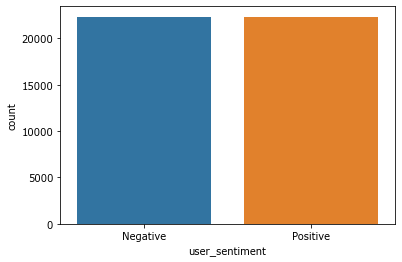

In [23]:
# Viewing the proportion of the 2 classes after text augmentation
sns.countplot(aug_df['user_sentiment'])

# lematization

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
# nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
 
lemmatizer = WordNetLemmatizer()
 
# Define function to lemmatize each word with its POS tag
 
# POS_TAGGER_FUNCTION : TYPE 1
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


def lemamtizer(*txt):
    
    txt = str(txt)
    # tokenize the review and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(txt)) 
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
        # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
        # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    lemmatized_sentence = lemmatized_sentence[3:-6]
    lemmatized_sentence = lemmatized_sentence.lstrip()
 
    return lemmatized_sentence    

In [25]:
# Testing lematization on a sample text
lemamtizer("I like working in many factories")

'I like work in many factory'

In [26]:
# Creating a dataframe to store the lematazied text in
text_df_lema = pd.DataFrame()
# Applying lematizatgion to the text data
text_df_lema['reviews'] = aug_df['reviews'].apply(lambda x: lemamtizer(x))
# Assigning the respactive classes
text_df_lema['user_sentiment'] = aug_df['user_sentiment']
# Viewing lematized dataframe
text_df_lema.head()

,reviews,user_sentiment
0,disappointed i read through the review on here...,Negative
1,irritation my husband buy this gel for us the ...,Negative
2,not worth it my boyfriend and i buy this to sp...,Negative
3,disappointing buy this early today and be exci...,Negative
4,not happy at all i buy this product for my hus...,Negative


## Note:
- Not removing stop words since it contains words such as "not", "wasnt", "isn't" ect.
- Removing the words can change the sentiment
- for example, " will not recommend" will become "will recommend"

# Splitting our data to train and test

In [27]:
# Splitting X and y
X = text_df_lema['reviews']
y = text_df_lema['user_sentiment']

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=33)

In [29]:
# Printing shape of the split data
print("Shape of X_train" ,X_train.shape)
print("Shape of X_test" ,X_test.shape)
print("Shape of y_train" ,y_train.shape)
print("Shape of y_test" ,y_test.shape)

Shape of X_train (29944,)
Shape of X_test (14750,)
Shape of y_train (29944,)
Shape of y_test (14750,)


## Tf-Idf vecctorizer

In [30]:
# Creating an instance of TfidfVectorizer 
tfidf = TfidfVectorizer()

In [31]:
# Fitting and transforming X_train
X_train_tfidf = tfidf.fit_transform(X_train)

In [32]:
X_train_tfidf

<29944x14048 sparse matrix of type '<class 'numpy.float64'>'
	with 753376 stored elements in Compressed Sparse Row format>

In [143]:
# Saving TFIDF as joblib file
file_name = 'tfidf_savedd'
joblib.dump(tfidf, file_name)

['tfidf_savedd']

# Building Classification models
- Logistic Regression
- Random Forest
- XG Boost

## Logistic Regression

In [34]:
# Creating instance of logistic regression model
log = LogisticRegression()

#### Using grid search to find the best hyperparameters

In [35]:
# Defining range of hyper parameter for the gridsearch
params = [
    {'penalty':['l1','l2', None], 
     'C': [0.001, 0.01, 1, 2, 3, 6, 9, 12, 15, 18, 21, 18,19, 24, 26, 28, 30, 32, 34],
     'solver':['lbfgs', 'newton-cg', 'liblinear',  'sag', 'saga']
     }
]

In [36]:
# Initializing grid 
grid = GridSearchCV(estimator=log, 
                    param_grid=params, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1, scoring ='accuracy')

In [37]:
# Fitting the data to the logistic regressio model using grid search
grid.fit(X_train_tfidf,y_train)

Fitting 5 folds for each of 285 candidates, totalling 1425 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 1, 2, 3, 6, 9, 12, 15, 18, 21, 18,
                                19, 24, 26, 28, 30, 32, 34],
                          'penalty': ['l1', 'l2', None],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             scoring='accuracy', verbose=1)

In [38]:
# Viewing choosen params
best_params = grid.best_params_
best_params

{'C': 26, 'penalty': 'l2', 'solver': 'saga'}

In [39]:
# Viewing results of grid search CV
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.132756,0.002028,0.000000,0.000000,0.001,l1,lbfgs,"{'C': 0.001, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,185
1,0.135195,0.007308,0.000000,0.000000,0.001,l1,newton-cg,"{'C': 0.001, 'penalty': 'l1', 'solver': 'newto...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,212
2,0.216065,0.009549,0.013057,0.002604,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.498247,0.498247,0.498247,0.498247,0.49833,0.498263,0.000033,133


#### Making predictions on test set

In [40]:
# Vectorizing test data
X_test_tfidf =  tfidf.transform(X_test)

In [41]:
# Using model to predict test data and storing in a "pred" variable
pred = grid.predict(X_test_tfidf)

### Evaluating Loigistic regression model

In [42]:
# Viewing classigication report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94      7427
    Positive       0.95      0.93      0.94      7323

    accuracy                           0.94     14750
   macro avg       0.94      0.94      0.94     14750
weighted avg       0.94      0.94      0.94     14750



In [43]:
# Viewing confusion matrix
print(confusion_matrix(y_test, pred))

[[7088  339]
 [ 501 6822]]


## Random forest

In [44]:
# Creating instance
forest = RandomForestClassifier()

In [45]:
# Creating a range of parameters for grid search cv
params = [
    {'max_depth':[2,4,6], 
     'min_samples_split': [2,4,6,8],
     'min_samples_leaf':[2,4,6,8],
     'criterion':['gini', 'entropy']
     }
]

In [46]:
# Initializing grid search
forest_grid = GridSearchCV(estimator=forest, 
                    param_grid=params, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1, scoring ='accuracy')

In [47]:
# Fitting the model to traning data
forest_grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [2, 4, 6, 8],
                          'min_samples_split': [2, 4, 6, 8]}],
             scoring='accuracy', verbose=1)

In [48]:
# Viewing best params
forest_grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 4}

In [146]:
# VIewing results of grid search CV
forest_cv_results = pd.DataFrame(forest_grid.cv_results_)
forest_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.410475,0.046003,0.149633,0.013401,gini,2,2,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.818000,0.817833,0.790616,0.792787,0.790581,0.801963,0.013050,92
1,1.427517,0.039992,0.152321,0.006446,gini,2,2,4,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.803306,0.810820,0.811321,0.833528,0.823981,0.816591,0.010762,71
2,1.400038,0.015173,0.152217,0.005944,gini,2,2,6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.819669,0.801469,0.802805,0.805978,0.792084,0.804401,0.008927,89
3,1.396550,0.024818,0.135502,0.010410,gini,2,2,8,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.804475,0.801302,0.800468,0.797963,0.807615,0.802365,0.003350,91
4,1.420215,0.035116,0.146952,0.007765,gini,2,4,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.799967,0.778928,0.803640,0.756220,0.817134,0.791178,0.021347,96


In [50]:
# Predicting on text data using best estimates
forest_pred = grid.predict(X_test_tfidf)

#### Random Forest Evaluation

In [51]:
# Viewing classification report
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94      7427
    Positive       0.95      0.93      0.94      7323

    accuracy                           0.94     14750
   macro avg       0.94      0.94      0.94     14750
weighted avg       0.94      0.94      0.94     14750



In [52]:
# Viewing confusion matrix
print(confusion_matrix(y_test, forest_pred))

[[7088  339]
 [ 501 6822]]


## XG Boost

In [53]:
# Initilizing XGB
xgb = XGBClassifier()

In [54]:
# Setting a range of params for random search cv
xg_params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50 ],
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.8, 0.9 ]
}

In [55]:
# creating an instancce of the random search with XGB
xg_grid = RandomizedSearchCV(estimator=xgb, 
                    param_distributions=xg_params, 
                    cv=5, 
                    verbose=1, 
                    n_iter=10,
                    n_jobs=-1, scoring ='accuracy')

In [56]:
# Traning the model 
xg_grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[15:58:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [57]:
# Viewing best estimator
xg_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.7, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [58]:
# Viewing best params
xg_grid.best_params_

{'min_child_weight': 5,
 'max_depth': 15,
 'learning_rate': 0.3,
 'gamma': 0.7,
 'colsample_bytree': 0.8}

In [59]:
# Viewing results of the random search
xg_cv_results = pd.DataFrame(xg_grid.cv_results_)
xg_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,30.925714,1.380535,0.050659,0.005872,3,8,0.35,0.2,0.3,"{'min_child_weight': 3, 'max_depth': 8, 'learn...",0.933378,0.935048,0.930205,0.933044,0.938544,0.934044,0.002736,4
1,38.831706,0.242192,0.045054,0.007141,5,10,0.3,0.4,0.7,"{'min_child_weight': 5, 'max_depth': 10, 'lear...",0.935882,0.935382,0.932877,0.934380,0.941717,0.936047,0.003015,2
2,10.897041,0.073821,0.043937,0.004448,5,3,0.2,0.4,0.7,"{'min_child_weight': 5, 'max_depth': 3, 'learn...",0.882451,0.881115,0.881449,0.885123,0.879092,0.881846,0.001969,10
3,23.611934,0.353149,0.050808,0.006660,3,6,0.3,0.0,0.7,"{'min_child_weight': 3, 'max_depth': 6, 'learn...",0.918684,0.923359,0.919686,0.923026,0.927522,0.922455,0.003121,8
4,57.785713,0.725219,0.039798,0.010274,5,15,0.3,0.7,0.8,"{'min_child_weight': 5, 'max_depth': 15, 'lear...",0.940057,0.942561,0.936717,0.942060,0.949065,0.942092,0.004046,1
5,42.332546,0.395300,0.046247,0.005077,5,10,0.15,0.2,0.5,"{'min_child_weight': 5, 'max_depth': 10, 'lear...",0.923693,0.927701,0.921690,0.922525,0.929192,0.924960,0.002955,7
6,44.709108,0.281531,0.046249,0.005098,7,12,0.25,0.4,0.7,"{'min_child_weight': 7, 'max_depth': 12, 'lear...",0.935882,0.935048,0.929871,0.934046,0.938377,0.934645,0.002784,3
7,39.985199,13.026174,0.036101,0.004579,1,15,0.05,0.5,0.3,"{'min_child_weight': 1, 'max_depth': 15, 'lear...",0.935882,0.931040,0.928536,0.932042,0.938043,0.933109,0.003417,5
8,17.655292,1.575278,0.038602,0.004288,1,6,0.45,0.5,0.7,"{'min_child_weight': 1, 'max_depth': 6, 'learn...",0.932877,0.931207,0.927534,0.930873,0.938043,0.932107,0.003437,6
9,8.703499,0.563201,0.038604,0.007130,3,3,0.5,0.0,0.4,"{'min_child_weight': 3, 'max_depth': 3, 'learn...",0.910169,0.905326,0.903490,0.909167,0.911323,0.907895,0.002985,9


In [60]:
# Predictiing on test set
xg_pred = xg_grid.predict(X_test_tfidf)

In [61]:
# Viewing classification report
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

    Negative       0.94      0.96      0.95      7427
    Positive       0.95      0.94      0.95      7323

    accuracy                           0.95     14750
   macro avg       0.95      0.95      0.95     14750
weighted avg       0.95      0.95      0.95     14750



In [62]:
# Viewing confusion matrix
print(confusion_matrix(y_test, xg_pred))

[[7094  333]
 [ 433 6890]]


#### Sellecting the XG boost model since it has the best performance

# Using XGB to train the entire dataset sine it had the best performance

In [63]:
# Full text dataset
text_df_lema.head()

,reviews,user_sentiment
0,disappointed i read through the review on here...,Negative
1,irritation my husband buy this gel for us the ...,Negative
2,not worth it my boyfriend and i buy this to sp...,Negative
3,disappointing buy this early today and be exci...,Negative
4,not happy at all i buy this product for my hus...,Negative


In [64]:
# Saperating text and class
X1 = text_df_lema['reviews']
y1 = text_df_lema['user_sentiment']

In [65]:
# Vectorising using the tfidf model that was previousky created
X1_tf =  tfidf.transform(X1)

In [66]:
# Creating instance of XG boost model with the best estimates
# xg_grid.best_estimator_

xg_boost = XGBClassifier(**xg_grid.best_params_)

In [67]:
# Traning the model with best estmates
xg_boost.fit(X1_tf, y1)

[15:58:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.7, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [144]:
# Saving xg_boost as joblib file
file_name = 'xgboost_savedd'
joblib.dump(xg_boost, file_name)

['xgboost_savedd']

# Recommendation system

In [69]:
# Loading dataset
df = pd.read_csv("C:\\Users\\Amit\\Desktop\\Capstone\\Data and code\\sample30.csv")
df.head(3)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive


In [70]:
# CHecking for percentage of null values for each variable
df.isnull().sum()/len(df['user_sentiment'])*100 

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

### Sellecting columns that are relevant for recommender system

In [71]:
# Number of users
len(df['reviews_username'].unique())

24915

In [72]:
# Number of products
len(df['name'].unique())

271

In [73]:
# Creating a df with relevant columns
df_rev = df[['reviews_username','id', 'reviews_rating']]

In [74]:
# Checking for null values
df_rev.isnull().sum()

reviews_username    63
id                   0
reviews_rating       0
dtype: int64

In [75]:
# Droping rows with missing data
df_rev = df_rev.dropna()

In [76]:
# Droping duplicate rows
df_rev = df_rev.drop_duplicates()

## Train test split

In [77]:
# Splitting to train and test set
train, test = train_test_split(df_rev, test_size=0.3, random_state=40)

In [78]:
# Viewing shape
print("Shape of Train set:" ,train.shape)
print("Shape of Test set:" ,test.shape)

Shape of Train set: (19417, 3)
Shape of Test set: (8322, 3)


In [79]:
# Creating pivot table using review_ratings as values
df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Creating dummy df 
- We create a dummy df to help us ignore the products that have already been rated by the user

In [80]:
# creating dummy train so we can make predictions only for items that havent been rated my the user
dummy_train = train.copy()

# Marking 1 for users that have already been rated by users
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

# Converting dummy train into a pivot table
dummy_train = dummy_train.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(1)

### Using adjusted cosine as a simalarity score

In [81]:
# creating a pivot table of traning set in order to compute cosine simalarity
df_pivot = train.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09mommy11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# Normalazing the movie ratings by subtracting the mean of the ratings form each user in 
# Normalization helps since different users have different rating schemes
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T - mean).T

In [83]:
df_subtracted.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# computing cosine simalarity
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
user_correlation[user_correlation<0] = 0

In [85]:
# Viewing user_correlation matrix
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
# Viewing shape of user_correlation matrix
user_correlation.shape

(17842, 17842)

## Prediction

In [87]:
# Taking the dot product of user_correlation and df_pivot in order to get the predicted ratings
user_predicted_rating = np.dot(user_correlation, df_pivot.fillna(0))

In [88]:
# VIewing shape of predicted ratings
user_predicted_rating.shape

(17842, 257)

In [89]:
# We multiply the predicted ratings with dummy train in order to filter out the ratings that were already given by the user
user_final_rating = np.multiply(user_predicted_rating, dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
# Saving user_final_rating as joblib file
file_name = 'user_pred_recc'
joblib.dump(user_final_rating, file_name)

['user_pred_recc']

# Evaluation

In [91]:
# FIltering out the common users from train set that are in the test set
common = test[test.reviews_username.isin(train.reviews_username)]

In [92]:
# creating a pivot table using the common user matrix
common_user_based_matrix = common.pivot_table(index = 'reviews_username', columns='id', values = 'reviews_rating')

In [93]:
# VIewing shape
common_user_based_matrix.shape

(887, 118)

In [94]:
# VIewing the dataframe
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37f5p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# COnverting user corelation matrix into a dataframe
user_correlation_df = pd.DataFrame(user_correlation)

In [96]:
# Setting user name as index
user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username', inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17832,17833,17834,17835,17836,17837,17838,17839,17840,17841
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# Creating a list of user names that are present in common
list_name = common.reviews_username.tolist()

# assigning column names 
user_correlation_df.columns = df_subtracted.index.tolist()



In [98]:
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T

In [99]:
# VIewing dataframe
user_correlation_df_3.head()

,00sab00,1witch,37f5p,aaron,abbey,abbi,abby,acjuarez08,adam,adriana9999,...,winniepoo2,wise,wizard,woowoo,worm,wvshopaholic,yeyo,yoadrian,yummy,zippy
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
user_correlation_df_3[user_correlation_df_3<0]=0

# Predicting ratings on the entire common user matrix
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.53300179, 0.        , ..., 0.17902872, 0.        ,
        0.        ]])

In [101]:
# Evaluating predictions by comparing it to ratings that have already been given by user
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [102]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [103]:
common_user_predicted_ratings.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [105]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [106]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [107]:
# COmputing root mean square error
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.558324862615715


# Predictions of Sentiments of Recommended Products for a given user

In [108]:
# Randomly sellecting a user (for testing purposes)
#user_name = user_final_rating.index[random.randint(1, 17000)]
#print(user_name)

# Sellecting a user name for recommendation
user_name = input("Input the user name")

rtullier


#### Preparing dataframe for sentiment analysis of recommended products

In [109]:
# Filtering out a list of the top 20 recommended product ids
top_20 = user_final_rating.loc[user_name].sort_values(ascending=False)[0:20].index

# Creating a dataframe with only the recommended products
top_20_df = df[df['id'].isin(top_20)][['id','reviews_title', 'reviews_text']]

# Droping na items from dataframe
top_20_df = top_20_df.dropna()

# Combining title and reviews and droping columns after combining
top_20_df['reviews'] = top_20_df['reviews_title'] + ' ' + top_20_df['reviews_text']
top_20_df = top_20_df.drop(['reviews_title', 'reviews_text'], 1)



#### Pre-processing data for sentiment analysis for recommended products

In [110]:
# Removing floating point digits
top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_float(x))
# Removing ints
top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_digit(x))
# Removing punctuation
top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_punct(x))
# Removing extra whitespaces
top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_extra_white_space(x))
# Removing leading and lagging whitespace
top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_white_strip(x)) 

In [111]:
# Viewing dataframe that shows the top 20 products for a user
top_20_df

,id,reviews
0,AV13O1A8GV-KLJ3akUyj,Just Awesome i love this album its very good m...
18211,AVpfDflP1cnluZ0-c5RJ,Cannot Recommend Defective Ordered this lamp o...
21915,AVpfN6Z71cnluZ0-gZmO,red itchy and bumpy irritation I bought this s...
21916,AVpfN6Z71cnluZ0-gZmO,new Caress bar soaps smell is way too strong T...
21917,AVpfN6Z71cnluZ0-gZmO,There is NO two pack Walmart will not fulfill ...
...,...,...
26757,AVpfPPkEilAPnD_xX3cP,I love this I love this
26758,AVpfPPkEilAPnD_xX3cP,light weight and effective I use this when jog...
26759,AVpfPPkEilAPnD_xX3cP,Great Sunblock for WHOLE Family This sunblock ...
26760,AVpfPPkEilAPnD_xX3cP,Best sunscreen ever and its SPF Just one thing...


# Passing the top 20 products through the Sentiment Analysis Model

In [112]:
# Lematizing text reviews of recommended products
top_20_lema = pd.DataFrame()
top_20_lema['reviews'] = top_20_df['reviews'].apply(lambda x: lemamtizer(x))
top_20_lema.head()

,reviews
0,Just Awesome i love this album its very good m...
18211,Can not Recommend Defective Ordered this lamp ...
21915,red itchy and bumpy irritation I buy this silk...
21916,new Caress bar soap smell be way too strong Th...
21917,There be NO two pack Walmart will not fulfill ...


In [113]:
# Vectorizing the text reviews for recommended products 
top_20_tfidf = tfidf.transform(top_20_lema['reviews'])

In [114]:
# Predicting sentiments of reviews of top 20 products
top_20_lema['pred'] = xg_boost.predict(top_20_tfidf)

In [115]:
# Combining ID Column to dataframe
top_20_lema['id'] = top_20_df['id']

In [116]:
# VIewing the dataframe
top_20_lema

,reviews,pred,id
0,Just Awesome i love this album its very good m...,Positive,AV13O1A8GV-KLJ3akUyj
18211,Can not Recommend Defective Ordered this lamp ...,Positive,AVpfDflP1cnluZ0-c5RJ
21915,red itchy and bumpy irritation I buy this silk...,Positive,AVpfN6Z71cnluZ0-gZmO
21916,new Caress bar soap smell be way too strong Th...,Positive,AVpfN6Z71cnluZ0-gZmO
21917,There be NO two pack Walmart will not fulfill ...,Negative,AVpfN6Z71cnluZ0-gZmO
...,...,...,...
26757,I love this I love this,Positive,AVpfPPkEilAPnD_xX3cP
26758,light weight and effective I use this when jog...,Positive,AVpfPPkEilAPnD_xX3cP
26759,Great Sunblock for WHOLE Family This sunblock ...,Positive,AVpfPPkEilAPnD_xX3cP
26760,Best sunscreen ever and its SPF Just one thing...,Positive,AVpfPPkEilAPnD_xX3cP


In [117]:
# Creating THe final dataframe with the top 20 products
fin = pd.DataFrame()
fin['items'] = top_20

# Mapping the product name from the product ID
fin['prod_name'] = df[df['id'].isin(top_20)]['name'].unique()

# Computing the Percentage of positive reviews
fin['positive_percent'] = fin['items'].apply(lambda x: top_20_lema[top_20_lema['id'] == x]['pred'].value_counts(normalize = True)[0])

In [118]:
fin

,items,prod_name,positive_percent
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),1.000000
1,AVpfDflP1cnluZ0-c5RJ,Kenroy Home Table Lamp - Chrome,1.000000
2,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0.852941
3,AVpfNVsj1cnluZ0-gNQN,Feit 60-Watt A19 Gu24 Base Led Light Bulb - So...,0.857143
4,AVpfNWbPilAPnD_xXPR7,Heiress (dvd),0.814815
5,AVpfNc9cLJeJML434tza,Mia Shower Curtain Green/brown - Lush Decor174,0.500000
6,AVpfNfEMLJeJML434uf-,Physicians Formula Powder Palette Mineral Glow...,1.000000
7,AVpfNglu1cnluZ0-gQ7x,"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",1.000000
8,AVpfO5u71cnluZ0-guiN,Switchmas (dvd),0.857143
9,AVpfOIrkilAPnD_xXgDG,Solo Foods Poppy Seed Cake and Pastry Filling,0.879433


#### TOP 5

In [119]:
# Filtering the top 5 based on percentage of positive reviews
fin.sort_values(by='positive_percent', ascending=False)[:5]

,items,prod_name,positive_percent
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),1.0
6,AVpfNfEMLJeJML434uf-,Physicians Formula Powder Palette Mineral Glow...,1.0
13,AVpfP-rELJeJML435jEN,Godzilla 3d Includes Digital Copy Ultraviolet ...,1.0
12,AVpfOrD0ilAPnD_xXrRj,Progresso Traditional Chicken Rice With Vegeta...,1.0
1,AVpfDflP1cnluZ0-c5RJ,Kenroy Home Table Lamp - Chrome,1.0


### This is used for deployment (same as above)
- Its the same as above but put into a single function

In [124]:
def predict_product(user_name):
    
    # Loading pickly files for predictions
    load_ml_model = joblib.load("xgboost_savedd")
    load_tfidf = joblib.load("tfidf_savedd")
    load_user_rec = joblib.load("user_pred_recc")


    # Filtering out a list of the top 20 recommended product ids
    top_20 = load_user_rec.loc[user_name].sort_values(ascending=False)[0:20].index
    # Creating a dataframe with only the recommended products
    top_20_df = df[df['id'].isin(top_20)][['id','reviews_title', 'reviews_text']]
    # Droping na items from dataframe
    top_20_df = top_20_df.dropna()
    # Combining title and reviews and droping columns after combining
    top_20_df['reviews'] = top_20_df['reviews_title'] + ' ' + top_20_df['reviews_text']
    top_20_df = top_20_df.drop(['reviews_title', 'reviews_text'], 1)
    
    # Removing floating point digits
    top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_float(x))
    # Removing ints
    top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_digit(x))
    # Removing punctuation
    top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_punct(x))
    # Removing extra whitespaces
    top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_extra_white_space(x))
    # Removing leading and lagging whitespace
    top_20_df['reviews'] = top_20_df['reviews'].apply(lambda x: remove_white_strip(x))    
    
    # Lematizing text reviews of recommended products
    top_20_lema = pd.DataFrame()
    top_20_lema['reviews'] = top_20_df['reviews'].apply(lambda x: lemamtizer(x))
    
    # Vectorizing the text reviews for recommended products 
    top_20_tfidf = load_tfidf.transform(top_20_lema['reviews'])
    # Sentiment based prediction for recommended products
    top_20_lema['pred'] = load_ml_model.predict(top_20_tfidf)
    # Combining ID Column to dataframe
    top_20_lema['id'] = top_20_df['id']
    
    # Creating THe final dataframe with the top 20 products
    fin = pd.DataFrame()
    fin['items'] = top_20
    # Mapping the product name from the product ID
    fin['prod_name'] = df[df['id'].isin(top_20)]['name'].unique()
    # Computing the Percentage of positive reviews
    fin['positive_percent'] = fin['items'].apply(lambda x: top_20_lema[top_20_lema['id'] == x]['pred'].value_counts(normalize = True)[0])
    # Filtering the top 5 based on percentage of positive reviews
    final = fin.sort_values(by='positive_percent', ascending=False)[:5]
    
    # Printing the top 5 products in a string format so flask can read it
    final_string=""
    for num,prod in enumerate(final['prod_name'].values, 1):
        final_string=final_string+' '+f"[{str(num)}] "+prod


    return final_string

## Note
- Unable to deploy the model on heruku since its exceeding the size limit. 
- The code runs fine on flask
- please take that into consideratation